In [1]:
import numpy as np
import torch
import os
import net
import utils
from PIL import Image
from tqdm import tqdm
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from torchvision.utils import save_image, make_grid
from time import time
import pickle
import random
from pathlib import Path

torch.manual_seed(0)
np.random.seed(0)
random.seed(0)

In [2]:
BATCH_SIZE = 32
DS_FOLDER = "/home/ML_courses/03683533_2021/dataset"
LR = 1e-4
DEVICE_ID = 0
VAL_RANGE = 1000
TRAIN_RANGE = None
NUM_WORKERS = 16
NUM_EPOCHS = 20
SHUFFLE = False
RUN_NAME = 'Alex-relu'

# Network and optimizer

In [3]:
model = net.AutoEncoder(activation="relu")
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
device = f'cuda:{DEVICE_ID}' if torch.cuda.is_available() else 'cpu'
print(device)
model.to(device)

cuda:0


/home/ML_courses/03683533_2021/maya_gal_ofek/condaEnv/lib/python3.8/site-packages/torch/cuda/__init__.py:120: UserWarning: 
    Found GPU%d %s which is of cuda capability %d.%d.
    PyTorch no longer supports this GPU because it is too old.
    The minimum cuda capability supported by this library is %d.%d.
    
  warnings.warn(old_gpu_warn.format(d, name, major, minor, min_arch // 10, min_arch % 10))


AutoEncoder(
  (activation): ReLU()
  (last_activation): Sigmoid()
  (enc1): Conv2d(3, 96, kernel_size=(11, 11), stride=(4, 4), padding=(4, 4))
  (enc1_bn): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (enc2): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (enc2_bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (enc3): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1))
  (enc3_bn): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (enc4): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1))
  (enc4_bn): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (enc5): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (enc5_bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (enc6): Conv2d(256, 1

# Data Loader & Dataset

In [4]:
transform = transforms.Compose([transforms.Resize(256),
                                transforms.ToTensor(),
                                ])

class UniDataset(Dataset):
    def __init__(self, image_paths, transform=None):
        self.image_paths = image_paths
        self.transform = transform
        
    def __getitem__(self, index):
        image_path = self.image_paths[index]
        x = Image.open(image_path)
        if self.transform is not None:
            x = self.transform(x)
        return x
    
    def __len__(self):
        return len(self.image_paths)

In [5]:
val_files = [os.path.join(DS_FOLDER,i) for i in sorted(os.listdir(DS_FOLDER))[:VAL_RANGE]]
if TRAIN_RANGE != None:
    train_files = [os.path.join(DS_FOLDER,i) for i in 
                   sorted(os.listdir(DS_FOLDER))[VAL_RANGE+1:TRAIN_RANGE+1+VAL_RANGE]]
else:
    train_files = [os.path.join(DS_FOLDER,i) for i in sorted(os.listdir(DS_FOLDER))[VAL_RANGE+1:]]

In [6]:
val_ds = UniDataset(val_files, transform=transform)
train_ds = UniDataset(train_files, transform=transform)

In [7]:
val_dl = DataLoader(val_ds, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS)
train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, pin_memory=True, shuffle=SHUFFLE)

/home/ML_courses/03683533_2021/maya_gal_ofek/condaEnv/lib/python3.8/site-packages/torch/utils/data/dataloader.py:478: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


# Train model

In [8]:
def save_imgs(true_imgs, val_imgs, dirname, epoch):
    path = os.path.join('results', RUN_NAME, epoch)
    os.makedirs(path, exist_ok=True)
    save_image(val_imgs, os.path.join(path, 'val_pred.png'))
    save_image(true_imgs, os.path.join(path, 'val_true.png'))

In [9]:
def calc_val_loss(val_dl, epoch, dirname):
    with torch.no_grad():
        val_loss = 0.0
        for images in val_dl:
            images = images.float().to(device)
            outputs = model(images)
            images.require_grad = False
            loss = criterion(outputs, images)
            val_loss += loss.item()
    images = images.cpu()
    outputs = outputs.view(outputs.size(0), 3, 256, 256).cpu().data
    save_imgs(images, outputs, dirname, epoch)
    return val_loss/len(val_dl), make_grid(images), make_grid(outputs)

In [10]:
%%time

train_losses = {}
val_losses = {}
for epoch in range(1, NUM_EPOCHS+1):
    t = time()
    train_loss = 0.0
    for images in tqdm(train_dl):
        images = images.float()
        images = images.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, images)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    val_loss, val_true_grid, val_pred_grid = calc_val_loss(val_dl, str(epoch), RUN_NAME)
    train_loss = train_loss/len(train_dl)
    train_losses[epoch] = train_loss
    val_losses[epoch] = val_loss
    print('Epoch: {} \tTraining Loss: {:.6f} \tVal Loss: {:.6f}\t \
    in time {:2f}m'.format(epoch, train_loss, val_loss, (time()-t)/60))


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 1219/1219 [02:05<00:00,  9.69it/s]


Epoch: 1 	Training Loss: 0.036485 	Val Loss: 0.015794	     in time 2.167366m


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 1219/1219 [02:07<00:00,  9.56it/s]


Epoch: 2 	Training Loss: 0.011235 	Val Loss: 0.008823	     in time 2.193316m


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 1219/1219 [02:07<00:00,  9.59it/s]


Epoch: 3 	Training Loss: 0.007462 	Val Loss: 0.006559	     in time 2.186892m


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 1219/1219 [02:06<00:00,  9.61it/s]


Epoch: 4 	Training Loss: 0.005906 	Val Loss: 0.005459	     in time 2.182481m


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 1219/1219 [02:06<00:00,  9.63it/s]


Epoch: 5 	Training Loss: 0.005136 	Val Loss: 0.004856	     in time 2.177536m


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 1219/1219 [02:06<00:00,  9.61it/s]


Epoch: 6 	Training Loss: 0.004639 	Val Loss: 0.004317	     in time 2.185034m


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 1219/1219 [02:06<00:00,  9.62it/s]


Epoch: 7 	Training Loss: 0.004144 	Val Loss: 0.003959	     in time 2.180199m


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 1219/1219 [02:06<00:00,  9.62it/s]


Epoch: 8 	Training Loss: 0.003910 	Val Loss: 0.003824	     in time 2.181142m


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 1219/1219 [02:07<00:00,  9.60it/s]


Epoch: 9 	Training Loss: 0.003780 	Val Loss: 0.003783	     in time 2.186639m


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 1219/1219 [02:07<00:00,  9.59it/s]


Epoch: 10 	Training Loss: 0.003678 	Val Loss: 0.003733	     in time 2.188965m


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 1219/1219 [02:06<00:00,  9.60it/s]


Epoch: 11 	Training Loss: 0.003587 	Val Loss: 0.003622	     in time 2.183896m


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 1219/1219 [02:07<00:00,  9.59it/s]


Epoch: 12 	Training Loss: 0.003511 	Val Loss: 0.003528	     in time 2.186973m


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 1219/1219 [02:06<00:00,  9.62it/s]


Epoch: 13 	Training Loss: 0.003439 	Val Loss: 0.003435	     in time 2.180731m


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 1219/1219 [02:06<00:00,  9.63it/s]


Epoch: 14 	Training Loss: 0.003393 	Val Loss: 0.003371	     in time 2.177219m


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1219/1219 [02:06<00:00,  9.63it/s]


Epoch: 15 	Training Loss: 0.003358 	Val Loss: 0.003325	     in time 2.178199m


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1219/1219 [02:06<00:00,  9.62it/s]


Epoch: 16 	Training Loss: 0.003304 	Val Loss: 0.003270	     in time 2.181035m


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1219/1219 [02:07<00:00,  9.59it/s]


Epoch: 17 	Training Loss: 0.003246 	Val Loss: 0.003216	     in time 2.186060m


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1219/1219 [02:06<00:00,  9.63it/s]


Epoch: 18 	Training Loss: 0.003199 	Val Loss: 0.003205	     in time 2.179336m


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1219/1219 [02:06<00:00,  9.62it/s]


Epoch: 19 	Training Loss: 0.003156 	Val Loss: 0.003173	     in time 2.183007m


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1219/1219 [02:06<00:00,  9.62it/s]


Epoch: 20 	Training Loss: 0.003140 	Val Loss: 0.003121	     in time 2.183731m
CPU times: user 37min 28s, sys: 11min 53s, total: 49min 21s
Wall time: 43min 38s


# Results

In [11]:
def show(img, ax = None):
    npimg = img.numpy()
    ax.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')
    
path = Path("results") / RUN_NAME

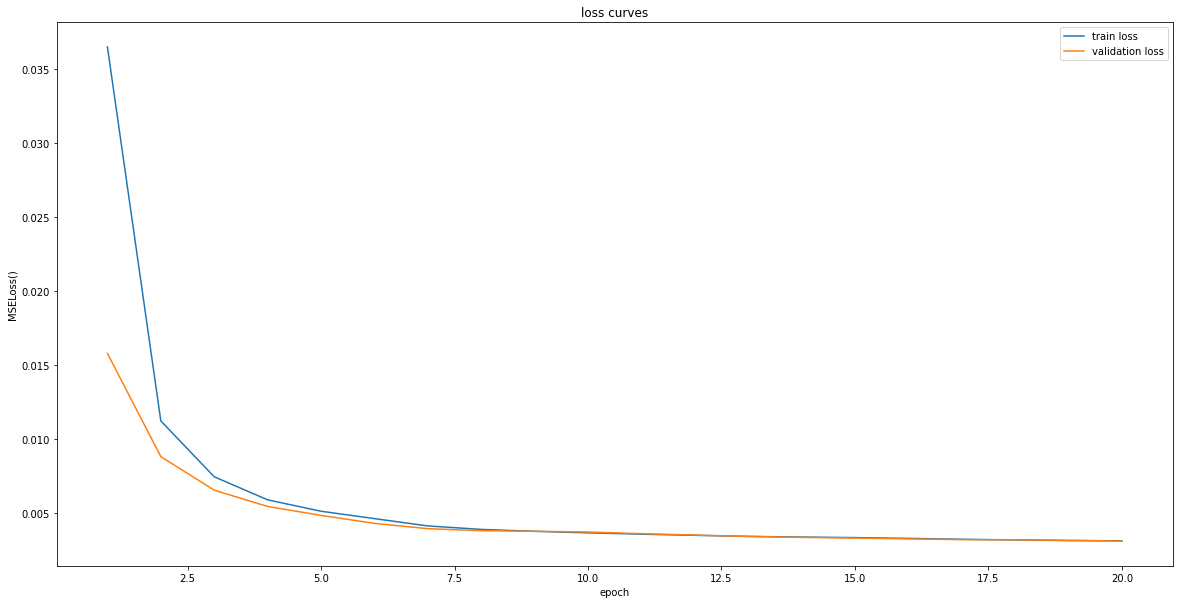

In [12]:
fig, ax = plt.subplots(figsize=(20, 10))
plt.plot(train_losses.keys(), train_losses.values(), label="train loss")
plt.plot(val_losses.keys(), val_losses.values(), label="validation loss")
plt.title("loss curves")
plt.legend()
plt.xlabel("epoch")
plt.ylabel(str(criterion))
plt.savefig(path / "loss_curves.png")

In [13]:
with open(path / "loss_values.txt", "w") as f:
    for i in train_losses.keys():
        f.write(f"epoch {i}: train loss is {train_losses[i]:.6f}, validation loss is {val_losses[i]:.6f}\n")

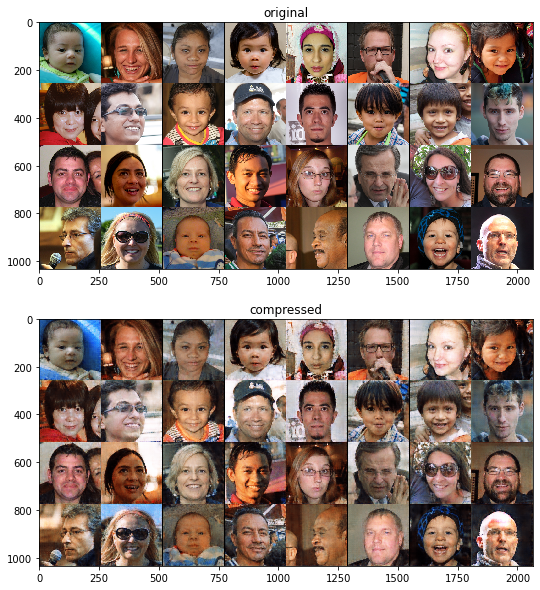

In [14]:
images = list(val_dl)[0]
outputs = model(images.to(device)).cpu()

fig, axes = plt.subplots(2, figsize=(20, 10))
show(make_grid(images), axes[0])
axes[0].set_title("original")
show(make_grid(outputs), axes[1])
axes[1].set_title("compressed")
plt.savefig( path / 'validation_compare.png')